### This notebook gives an overview of using the parsons library by giving an example of a simple analysis workflow using a public S3 bucket. This workflow takes data from a dataset of indexed hiring rates during the pandemic, and I show how one can get the data, combine it with other datasets, do some analysis in python and then upload the data output and other data assets to a database (or many other endpoints).

In [73]:
#Public documentation on this bucket at: https://registry.opendata.aws/us-hiring-rates-pandemic/
EXAMPLE_BUCKET_NAME = 'greenwichhr-covidjobimpacts'
AWS_ACCESS_KEY_ID='MY_KEY'
AWS_SECRET_ACCESS_KEY='MY_SECRET'


### The simplest task one can do with s3 is list the objects in a public s3 bucket. With the parsons library this is relatively straight-foward: initalize an S3 class and list the keys (one can think of them as files) for the given bucket. To do this, one will have to submit AWS credentials. If you already have them stored in a credential file you may not need to supply them, if not you'll need to adjust the static variables above with your credentials.

In [74]:
from parsons import S3, Table

try:
    s3 = S3()
    s3.list_keys(EXAMPLE_BUCKET_NAME)
except Exception:
    s3 = S3(aws_access_key_id=AWS_ACCESS_KEY_ID, aws_secret_access_key=AWS_SECRET_ACCESS_KEY)
    s3.list_keys(EXAMPLE_BUCKET_NAME)

### The s3 class has a number of convenience functions to get and post data to a variety of sources. In the following we use the get_file method, which generates a temp file to your local machine that can be loaded in various ways. In this example I show how to load this temp file into a pandas dataframe. Getting a file in this way is particularly useful for formats other than CSV (json, images, etc).

In [75]:
import pandas as pd

#Filenames in the bucket are the keys to the dictionary, so we turn them into a list for easier use
files = list(s3.list_keys(EXAMPLE_BUCKET_NAME).keys())
temp_loc = s3.get_file(EXAMPLE_BUCKET_NAME, files[-3])

#To show you can load and interact with this temp file
df = pd.read_csv(temp_loc)
df.head()

post_date                    job_family  count_id_indexed
0  2020-03-01                           NaN               1.0
1  2020-03-01              Customer Service               1.0
2  2020-03-01  Entertainment and Recreation               1.0
3  2020-03-01             Facilities/Constr               1.0
4  2020-03-01             Finance/Insurance               1.0

### Instead of generating a temp file with the get_file method, one can use the from_s3_csv to generate a Table instance directly.

In [86]:
try:
    example_table = Table.from_s3_csv(EXAMPLE_BUCKET_NAME, files[-3])
except Exception:
    example_table = Table.from_s3_csv(
        EXAMPLE_BUCKET_NAME, 
        files[-3],
        aws_access_key_id=AWS_ACCESS_KEY_ID, 
        aws_secret_access_key=AWS_SECRET_ACCESS_KEY
    )
example_table

{'post_date': '2020-03-01', 'job_family': '', 'count_id_indexed': '1.0000'}
{'post_date': '2020-03-01', 'job_family': 'Customer Service', 'count_id_indexed': '1.0000'}
{'post_date': '2020-03-01', 'job_family': 'Entertainment and Recreation', 'count_id_indexed': '1.0000'}
{'post_date': '2020-03-01', 'job_family': 'Facilities/Constr', 'count_id_indexed': '1.0000'}
{'post_date': '2020-03-01', 'job_family': 'Finance/Insurance', 'count_id_indexed': '1.0000'}
...

### The Table class has good interoperability with a number of formats. The following is an example on how it can be directly passed and built into a pandas dataframe. Once we have it in a dataframe, we filter to hospitality staff as our simple analysis is concerned with industries like hospitality that were greatly affected by the pandemic.

In [87]:
example_df = pd.DataFrame(example_table)
example_df = example_df.loc[example_df['job_family']=='Hospitality Staff']
example_df.head()

post_date         job_family count_id_indexed
7   2020-03-01  Hospitality Staff           1.0000
26  2020-03-02  Hospitality Staff           1.0144
45  2020-03-03  Hospitality Staff           1.0416
64  2020-03-04  Hospitality Staff           1.0698
83  2020-03-05  Hospitality Staff           1.0716

### Now that our data is in a dataframe, we can do anything we do in any other workflow with dataframes. Here I clean our data and plot the time series of the number of jobs indexed against pre-pandemic.

Text(0.5, 1.0, 'Hospitality Jobs Indexed')

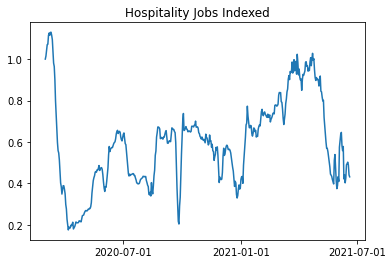

In [89]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

def try_convert_float(x):
    try:
        return float(x.strip())
    except Exception:
        return np.nan

example_df['post_date'] = pd.to_datetime(example_df['post_date'])
example_df['count_id_index_corrected'] = example_df['count_id_indexed'].apply(try_convert_float)
plt.plot(example_df['post_date'], example_df['count_id_index_corrected'])
plt.gca().set_xticks(["2020-07-01", "2021-01-01", "2021-07-01"]) 
plt.title("Hospitality Jobs Indexed")

### For this simple analysis, I was interested in the relationship between the number of new cases and the changes to hospitality job openings, so I bring in the CDC data on COVID cases and deaths.

In [90]:
us_covid_numbers = pd.read_csv('https://data.cdc.gov/resource/9mfq-cb36.csv')
us_covid_needed = us_covid_numbers.loc[:, ['submission_date', 'state', 'new_case', 'new_death']]
us_covid_needed.head()

submission_date state  new_case  new_death
0  2021-01-25T00:00:00.000    NE     646.0       15.0
1  2020-01-25T00:00:00.000    OR       0.0        0.0
2  2020-07-23T00:00:00.000    KY     607.0        7.0
3  2021-02-01T00:00:00.000    DC     136.0        3.0
4  2021-05-11T00:00:00.000    NJ     561.0       31.0

### The CDC data is given by state so we need to do some cleanup by aggregating, converting, and renaming some columns.

In [91]:
us_covid_aggregated = us_covid_needed.groupby(['submission_date'])['new_case', 'new_death'].sum().reset_index()
us_covid_aggregated['submission_date'] = pd.to_datetime(us_covid_aggregated['submission_date'])
us_covid_aggregated.columns = ['post_date', 'new_case', 'new_death']
us_covid_aggregated.head()

post_date  new_case  new_death
0 2020-01-22       0.0        0.0
1 2020-01-23       0.0        0.0
2 2020-01-24       0.0        0.0
3 2020-01-25       0.0        0.0
4 2020-01-26       0.0        0.0

### We then join our two dataframes together on data to get our output dataset. We'd like to put these cases and deaths in the same range as the jobs indexed, so I min max scale them to be between 0 and 1.

In [92]:
def scale_column(column):
    X = column
    return (X - X.min()) / (X.max() - X.min())


output_df = pd.merge(example_df, us_covid_aggregated, how='left', on='post_date')
output_df['new_cases_scaled'] = scale_column(output_df['new_case'])
output_df['new_deaths_scaled'] = scale_column(output_df['new_death'])
output_df.head()

post_date         job_family count_id_indexed  count_id_index_corrected  \
0 2020-03-01  Hospitality Staff           1.0000                    1.0000   
1 2020-03-02  Hospitality Staff           1.0144                    1.0144   
2 2020-03-03  Hospitality Staff           1.0416                    1.0416   
3 2020-03-04  Hospitality Staff           1.0698                    1.0698   
4 2020-03-05  Hospitality Staff           1.0716                    1.0716   

   new_case  new_death  new_cases_scaled  new_deaths_scaled  
0       1.0        0.0          0.000035           0.007795  
1       0.0        5.0          0.000000           0.013363  
2      26.0        3.0          0.000918           0.011136  
3       0.0        0.0          0.000000           0.007795  
4      86.0        1.0          0.003038           0.008909

### Now that we have our output dataframe, we can plot them together to see the relationship between our variables. We save a figure of this output to share and we'll save this dataset to share with our team to do further analysis.

Text(0.5, 1.0, 'Hospitality Jobs Indexed')

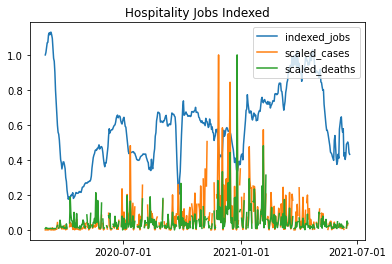

In [93]:
plt.plot(output_df['post_date'], output_df['count_id_index_corrected'], label='indexed_jobs')
plt.plot(output_df['post_date'], output_df['new_cases_scaled'], label='scaled_cases')
plt.plot(output_df['post_date'], output_df['new_deaths_scaled'], label='scaled_deaths')
plt.gca().set_xticks(["2020-07-01", "2021-01-01", "2021-07-01"]) 
plt.legend(loc='upper right')
plt.title("Hospitality Jobs Indexed")

### We now convert our dataframe back into a Table instance by using the from_dataframe method. Doing this conversion gives us access to a number of helper methods to save our data. 

In [94]:
output_table = Table.from_dataframe(example_df)
output_table

{'post_date': Timestamp('2020-03-01 00:00:00'), 'job_family': 'Hospitality Staff', 'count_id_indexed': '1.0000', 'count_id_index_corrected': 1.0}
{'post_date': Timestamp('2020-03-02 00:00:00'), 'job_family': 'Hospitality Staff', 'count_id_indexed': '1.0144', 'count_id_index_corrected': 1.0144}
{'post_date': Timestamp('2020-03-03 00:00:00'), 'job_family': 'Hospitality Staff', 'count_id_indexed': '1.0416', 'count_id_index_corrected': 1.0416}
{'post_date': Timestamp('2020-03-04 00:00:00'), 'job_family': 'Hospitality Staff', 'count_id_indexed': '1.0698', 'count_id_index_corrected': 1.0698}
{'post_date': Timestamp('2020-03-05 00:00:00'), 'job_family': 'Hospitality Staff', 'count_id_indexed': '1.0716', 'count_id_index_corrected': 1.0716}
...

### Now that it's a table we can use helper methods to output to a variety of formats. In the following cell, I give examples on how to do this to output to a csv, postgres, or an S3 bucket.

In [95]:
#To write to a local csv
output_table.to_csv('hospitality_jobs_ts.csv')

#To upload to a database
#output_table.to_postgres('TABLE_NAME', 'USERNAME', 'PASSWORD', 'HOST', 'DB', 'PORT')

#To upload to s3
#output_table.to_s3_csv('BUCKET', 'KEY')
#If you need credentials
#output_table.to_s3_csv('BUCKET, 'KEY', 'AWS_ACCESS_KEY_ID', 'AWS_SECRET_ACCESS_KEY')

'hospitality_jobs_ts.csv'

### Finally, we aren't limited to CSVs, we can store any type of file on an S3 bucket. Here I take the jpeg of the figure we generated and store it to S3.

In [96]:
#Can also save any arbitrary file to s3
output_s3 = S3()
try:
    output_s3.put_file('THIS_BUCKET_DOES_NOT_EXIST', 'hospitality_jobs_ts.jpeg', './hospitality_jobs_ts.jpeg')
except Exception:
    print("This doesn't work because the bucket isn't real")

This doesn't work because the bucket isn't real


### Resources
1. Parsons documentation: https://move-coop.github.io/parsons/html/index.html
2. Pandas documentation: https://pandas.pydata.org/docs/
3. Matplotlib documentation: https://matplotlib.org/stable/contents.html